In [1]:
import pandas as pd
import numpy as np
import datetime
import glob
import os
import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from tqdm import tqdm
import plotly.express as px # express 통해서 그리기
from plotly.subplots import make_subplots
import plotly.graph_objects as go
plt.rc('font', family='Malgun Gothic')
import networkx as nx
did_info=['현관','복도스팟1','복도스팟2','주방다운','주방','복도스팟3','거실스팟1','거실스팟2','거실1','거실2','거실3','안방','발코니1','방1','방2','욕실1','드레스룸','대피공간','옷장 센서','욕실 다운','욕실2','발코니2','식탁']

In [2]:
#데이터 불러오기
data=pd.read_csv('D:/주거_조명/1208동 2202호/report_data_0016.csv')
data=data.drop('Unnamed: 0',axis=1)
data['hist_dt']=pd.to_datetime(data['hist_dt'])

#lid 정보 불러오기
lid=pd.read_csv('D:/주거_조명/1210동 1602호/어울림하트 아파트 1210동 1602호.csv ',encoding='cp949')

#lightNo대로 정렬
lid=lid.sort_values(by=['lightNo'])
lid=lid.reset_index(drop=True)
#조명모듈 lid만 가져오기
lid=lid.iloc[0:23]
#x좌표 y좌표 따기
x=lid['x']
y=lid['z']
#did
light_0004_did=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
#did별로 분류
#중복된 시간도 삭제
for i in light_0004_did:
    globals()['data_'+str(i)]=data[data['did']==i]
    #globals()['data_'+str(i)]=globals()['data_'+str(i)].set_index('hist_dt')
    globals()['data_'+str(i)]=globals()['data_'+str(i)].rename(columns={'message':'message_'+str(i)})
    globals()['data_'+str(i)]=globals()['data_'+str(i)][['hist_dt','message_'+str(i)]]
    globals()['data_'+str(i)]=globals()['data_'+str(i)].reset_index(drop=True)
    globals()['data_'+str(i)]=globals()['data_'+str(i)][~globals()['data_'+str(i)].duplicated(subset='hist_dt')]

In [3]:
#각 조명 켜질 확률 구하기
for i in tqdm(light_0004_did):
    globals()['data_'+str(i)+'_on']=(globals()['data_'+str(i)])[(globals()['data_'+str(i)])['message_'+str(i)]=='0 (켜진 상태)']
    globals()['data_'+str(i)+'_on']=globals()['data_'+str(i)+'_on'].reset_index(drop=True)
for i in tqdm(light_0004_did):
    globals()['data'+str(i)+'_on_per']=len(globals()['data_'+str(i)+'_on'])/len(globals()['data_'+str(i)])
a=[]
for i in tqdm(light_0004_did):
    a.append(globals()['data'+str(i)+'_on_per'])
on={'켜질 확률':a}
result_on_per=pd.DataFrame(on,index=light_0004_did)
result_on_per
#조명 당 같이 켜지는 확률 구하기

#조명끼리 쌍으로 데이터프레임 집합 만들기
#data_1_2->1번 디바이스 데이터프레임과 2번 디바이스 데이터프레임
for i in tqdm(light_0004_did):
    for j in light_0004_did:
        if (i!=j):
            globals()['data_'+str(i)+'_'+str(j)]=pd.merge(globals()['data_'+str(i)],globals()['data_'+str(j)])
            
#두 쌍이 동시에 켜진 데이터프레임 만들기
#data_1_2_on
for i in tqdm(light_0004_did):
    for j in light_0004_did:
        if (i!=j):
            globals()['data_'+str(i)+'_'+str(j)+'_on']=(globals()['data_'+str(i)+'_'+str(j)])[(globals()['data_'+str(i)+'_'+str(j)]['message_'+str(i)]=='0 (켜진 상태)')&(globals()['data_'+str(i)+'_'+str(j)]['message_'+str(j)]=='0 (켜진 상태)')]
            globals()['data_'+str(i)+'_'+str(j)+'_on']=globals()['data_'+str(i)+'_'+str(j)+'_on'].reset_index(drop=True)


#교집합확률 구하기
#data_1_2_on_per 1번2번 동시에 켜진 데이터프레임
#result_on_both_per 동시에 켜진 모든결과
b=[]
for i in tqdm(light_0004_did):
    for j in light_0004_did:
        if (i!=j):
            globals()['data_'+str(i)+'_'+str(j)+'_on_per']=len(globals()['data_'+str(i)+'_'+str(j)+'_on'])/len(globals()['data_'+str(i)+'_'+str(j)])
            b.append(globals()['data_'+str(i)+'_'+str(j)+'_on_per'])
on_both={'동시에 켜질 확률':b}
device_both=[]
for i in light_0004_did:
    for j in light_0004_did:
        if(i!=j):
            device_both.append((i,j))
result_on_both_per=pd.DataFrame(on_both,index=device_both)


#신뢰도
for i in tqdm(light_0004_did):
    for j in light_0004_did:
        if i!=j:
            if globals()['data'+str(i)+'_on_per']==0:
                globals()['confidence_'+str(i)+'_'+str(j)]=0
            else:
                globals()['confidence_'+str(i)+'_'+str(j)]=globals()['data_'+str(i)+'_'+str(j)+'_on_per']/globals()['data'+str(i)+'_on_per']
                
#소수점 셋째자리까지
for i in tqdm(light_0004_did):
    for j in light_0004_did:
        if i!=j:
            globals()['confidence_'+str(i)+'_'+str(j)]=round(globals()['confidence_'+str(i)+'_'+str(j)],3)

100%|███████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 22996.18it/s]


In [4]:
#사이즈 조절할때 필요한 켜진 조명시간 데이터프레임 만들기
#2,17,18번 7번 8번 14번
df=data.groupby(['did','message']).count()
df
df1=df[['gid']]
df1=df1.rename(columns={'gid':'time'})
df1
rs=[]
for i in [1,3,4,5,6,9,10,11,12,13,15,16,19,20,21,22,23]:
    rs.append(df1['time'].loc[i,'0 (켜진 상태)'])
rs.sort()
rs

[1, 4, 10, 29, 36, 45, 46, 67, 73, 115, 222, 256, 812, 887, 930, 1246, 1405]

In [5]:
#edge에 담을 list 만들기
#pattern_1_2
for i in tqdm(light_0004_did):
    for j in light_0004_did:
        if (i!=j):
            globals()['pattern_'+str(i)+'_'+str(j)]=[]
#패턴에 담기
#(2번디바이스,3번디바이스,가중치)
for i in tqdm(light_0004_did):
    for j in light_0004_did:
        if (i!=j):
            globals()['pattern_'+str(i)+'_'+str(j)].append((did_info[i-1],did_info[j-1],{'confidence':globals()['confidence_'+str(i)+'_'+str(j)]}))

100%|███████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 23178.52it/s]


In [6]:
#신뢰도가 50프로 이상인것만 만들기
for i in tqdm(light_0004_did):
    for j in light_0004_did:
        if (i!=j):
            if globals()['confidence_'+str(i)+'_'+str(j)]>0.5:
                globals()['confidence_50over_'+str(i)+'_'+str(j)]=globals()['confidence_'+str(i)+'_'+str(j)]

#edge에 담을 list 만들기
#pattern_1_2
for i in tqdm(light_0004_did):
    for j in light_0004_did:
        if (i!=j):
            if globals()['confidence_'+str(i)+'_'+str(j)]>0.5:
                globals()['pattern50_'+str(i)+'_'+str(j)]=[]
#패턴에 담기
#(2번디바이스,3번디바이스,가중치)
for i in tqdm(light_0004_did):
    for j in light_0004_did:
        if (i!=j):
            if globals()['confidence_'+str(i)+'_'+str(j)]>0.5:
                globals()['pattern50_'+str(i)+'_'+str(j)].append((did_info[i-1],did_info[j-1],{'confidence':globals()['confidence_50over_'+str(i)+'_'+str(j)]}))                
    

100%|██████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<?, ?it/s]


In [7]:
#신뢰도 70프로 이상인것들만 출력
#(1->2) 1번이 켜졌을때 2번이 켜질 확률이 70프로 이상
#끝에 숫자는 다른 조명들과 연관성이 가장 높음
per_70_device=[]
per_70=[]
number_end=[]
number_start=[]
per=[]
for i in tqdm(light_0004_did):
    for j in light_0004_did:
        if (i!=j):
            if globals()['confidence_'+str(i)+'_'+str(j)]>0.7:
                per_70_device.append((did_info[i-1],did_info[j-1]))
                per_70.append(globals()['confidence_'+str(i)+'_'+str(j)])
                number_end.append(did_info[j-1])
                number_start.append(did_info[i-1])
                per.append(globals()['confidence_'+str(i)+'_'+str(j)])
                

per_70_df=pd.DataFrame(per_70,index=per_70_device,columns=['70%이상 켜질확률'])
per_70_df



100%|██████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<?, ?it/s]


,70%이상 켜질확률
"(복도스팟2, 복도스팟3)",0.978
"(복도스팟2, 거실3)",0.761
"(주방, 식탁)",0.838
"(복도스팟3, 복도스팟2)",1.000
"(복도스팟3, 거실3)",0.778
"(거실1, 거실2)",1.000
"(거실2, 거실3)",0.847
"(거실3, 거실2)",0.751
"(발코니1, 주방)",1.000
"(발코니1, 거실2)",1.000


In [8]:
#결과값 데이터프레임
index=pd.MultiIndex.from_tuples(per_70_device)
result1=pd.DataFrame(per,index=index,columns=['A가 켜졌을때 B가 켜질 확률'])
result1.index.names=["A","B"]
result1

A가 켜졌을때 B가 켜질 확률
A     B                      
복도스팟2 복도스팟3             0.978
      거실3               0.761
주방    식탁                0.838
복도스팟3 복도스팟2             1.000
      거실3               0.778
거실1   거실2               1.000
거실2   거실3               0.847
거실3   거실2               0.751
발코니1  주방                1.000
      거실2               1.000
      거실3               1.000
      안방                1.000
      방2                1.000
      식탁                1.000
욕실 다운 욕실2               0.932
식탁    주방                0.959

In [9]:
did_info=['현관','복도스팟1','복도스팟2','주방다운','주방','복도스팟3','거실스팟1','거실스팟2','거실1','거실2','거실3','안방','발코니1','방1','방2','욕실1','드레스룸','대피공간','옷장 센서','욕실 다운','욕실2','발코니2','식탁']

# 밥먹고와서 향상도 부터

In [10]:

for i in tqdm(light_0004_did):
    for j in light_0004_did:
        if (i!=j):
            if globals()['data'+str(i)+'_on_per']==0:
                globals()['lift_'+str(i)+'_'+str(j)]=0
            elif globals()['data'+str(j)+'_on_per']==0:
                globals()['lift_'+str(i)+'_'+str(j)]=0
            else:
                globals()['lift_'+str(i)+'_'+str(j)]=globals()['data_'+str(i)+'_'+str(j)+'_on_per']/(globals()['data'+str(i)+'_on_per']* globals()['data'+str(j)+'_on_per'])

100%|███████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 23034.62it/s]


In [11]:
for i in tqdm(light_0004_did):
    for j in light_0004_did:
        if (i!=j):
            globals()['lift_'+str(i)+'_'+str(j)]=round(globals()['lift_'+str(i)+'_'+str(j)],3)

100%|███████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 23239.94it/s]


In [12]:
#향상도가 1이상인것만 뽑기
per_more1_device=[]
per_more1=[]
for i in tqdm(light_0004_did):
    for j in light_0004_did:
        if (i!=j):
            if globals()['lift_'+str(i)+'_'+str(j)]>1:
                per_more1_device.append((did_info[i-1]+'->'+did_info[j-1]))
                per_more1.append(globals()['lift_'+str(i)+'_'+str(j)])
#데이터프레임 만들기
per_more1_df=pd.DataFrame(per_more1,index=per_more1_device,columns=['향상도 1이상 값'])
per_more1_df

100%|███████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 23001.67it/s]


,향상도 1이상 값
현관->복도스팟2,21.558
현관->주방,3.999
현관->복도스팟3,22.037
현관->거실2,2.587
현관->거실3,2.470
...,...
식탁->욕실1,3.911
식탁->옷장 센서,1.374
식탁->욕실 다운,7.077
식탁->욕실2,5.161


In [13]:
#향상도 신뢰도 다 고려한것
result3_device=[]
result3_per=[]
lift_per=[]
for i in tqdm(light_0004_did):
    for j in light_0004_did:
        if (i!=j):
            if globals()['confidence_'+str(i)+'_'+str(j)]>0.7:
                if globals()['lift_'+str(i)+'_'+str(j)]>1:
                    result3_device.append((did_info[i-1],did_info[j-1]))
                    result3_per.append(globals()['confidence_'+str(i)+'_'+str(j)])
                    lift_per.append(globals()['lift_'+str(i)+'_'+str(j)])
                
test2134=['일치','일치','불일치','일치','일치','불일치','일치','일치','불일치','불일치','불일치',
        '일치','불일치','일치','일치','불일치','일치' ]
#결과값 데이터프레임
index=pd.MultiIndex.from_tuples(result3_device)
result3=pd.DataFrame({'A가 켜졌을때 B가 켜질 확률(신뢰도)':result3_per,'향상도':lift_per},index=index)
result3.index.names=["A","B"]
result3

100%|██████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<?, ?it/s]


A가 켜졌을때 B가 켜질 확률(신뢰도)      향상도
A     B                                    
복도스팟2 복도스팟3                  0.978  194.022
      거실3                    0.761    4.833
주방    식탁                     0.838    9.207
복도스팟3 복도스팟2                  1.000  194.022
      거실3                    0.778    4.941
거실1   거실2                    1.000    7.163
거실2   거실3                    0.847    5.379
거실3   거실2                    0.751    5.379
발코니1  주방                     1.000    9.597
      거실2                    1.000    7.163
      거실3                    1.000    6.352
      안방                     1.000  133.209
      방2                     1.000   10.062
      식탁                     1.000   10.991
욕실 다운 욕실2                    0.932   72.293
식탁    주방                     0.959    9.207

100%|███████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 23007.15it/s]


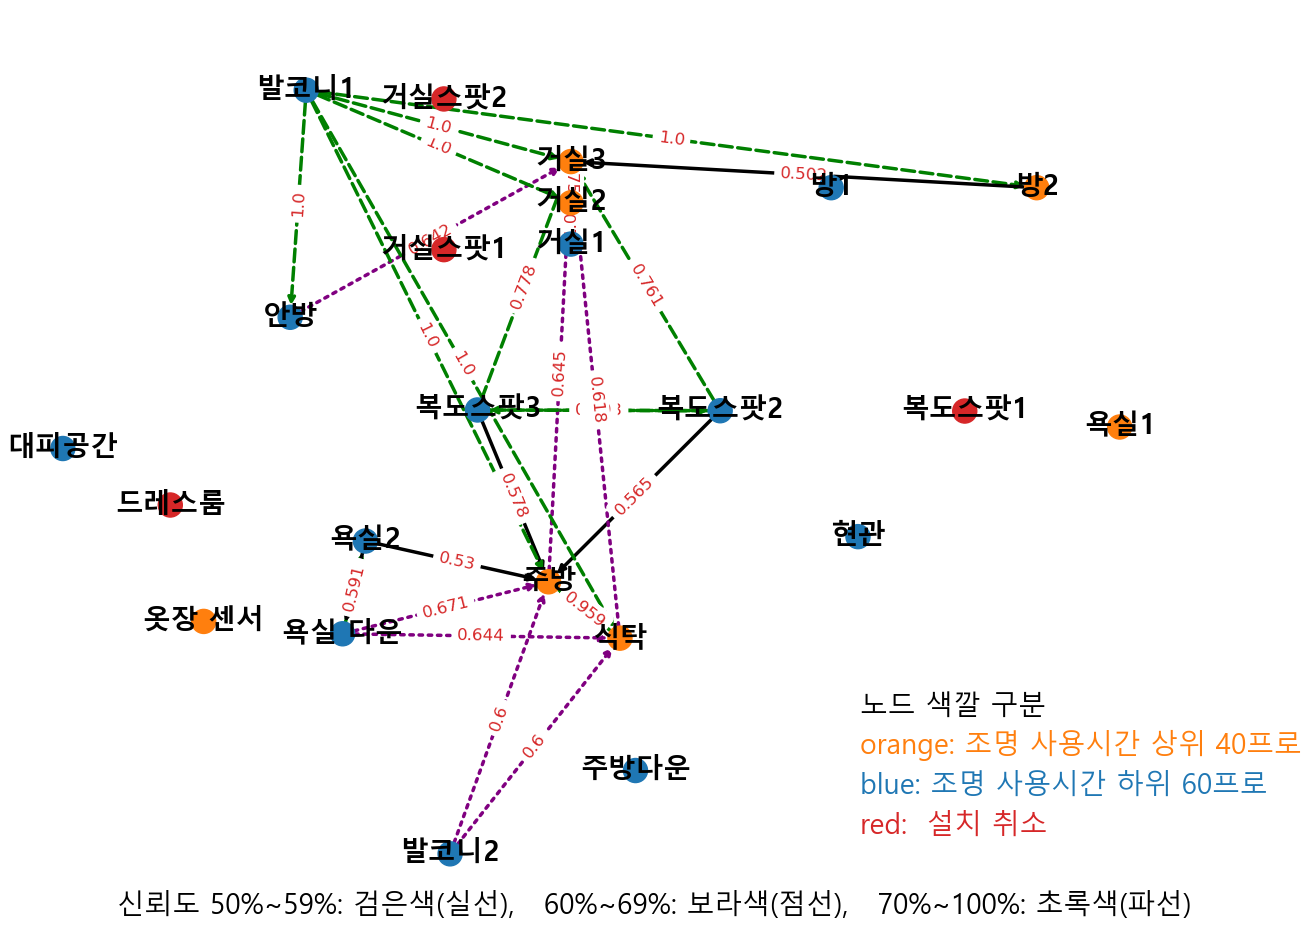

In [15]:
#H 그래프
H = nx.DiGraph()
#did로 노드 추가
H.add_nodes_from(did_info)
#노드속성 켜진 시간으로 
for i in [1,3,4,5,6,9,10,11,12,13,15,16,19,20,21,22,23]:
    H.nodes[did_info[i-1]]['on_time']=df1['time'].loc[i,'0 (켜진 상태)']
    H.nodes[did_info[i-1]]['on']=0
H.nodes[did_info[1]]['on_time']=0
H.nodes[did_info[1]]['on']=1
H.nodes[did_info[6]]['on_time']=0
H.nodes[did_info[6]]['on']=1
H.nodes[did_info[7]]['on_time']=0
H.nodes[did_info[7]]['on']=1
H.nodes[did_info[13]]['on_time']=1
H.nodes[did_info[13]]['on']=1
H.nodes[did_info[16]]['on_time']=0
H.nodes[did_info[16]]['on']=1
H.nodes[did_info[17]]['on_time']=1
H.nodes[did_info[17]]['on']=1
#node 속성에 따라 크기 설정하기 위해 node 속성만 가져옴
size_node=nx.get_node_attributes(H,'on_time')
size_device=[size_node.get(node) for node in H.nodes()]
#노드 위치 추가
#노두 위치 추가
test_lid={}
for i in range(23):
    test_lid[did_info[i]]=[x[i],y[i]]
test_lid
#색상 변경
#색상 변경
color_map=nx.get_node_attributes(H,'on_time')
for key in color_map:
    if color_map[key]==0:
        color_map[key]="tab:red"
    elif color_map[key]>=222:
        color_map[key]='tab:orange'
    else:
        color_map[key]='tab:blue'
color_device=[color_map.get(node) for node in H.nodes()]
#엣지추가
for i in tqdm(light_0004_did):
    for j in light_0004_did:
        if i!=j:
            if globals()['confidence_'+str(i)+'_'+str(j)]>0.5:
                H.add_edges_from(globals()['pattern50_'+str(i)+'_'+str(j)])
#엣지 색깔
edge_color_map=nx.get_edge_attributes(H,'confidence')
for key in edge_color_map:
    if edge_color_map[key]>=0.7:
        edge_color_map[key]='green'
    elif (edge_color_map[key]>=0.5)&(edge_color_map[key]<0.6):
        edge_color_map[key]='black'
    elif (edge_color_map[key]>=0.6)&(edge_color_map[key]<0.7):
        edge_color_map[key]='purple'
edge_colors=[edge_color_map.get(edge) for edge in H.edges()]            

#엣지 정보
edge_labels = dict([((n1, n2), d['confidence'])
                    for n1, n2, d in H.edges(data=True)])
#엣지 넓이
edges = H.edges()
test=[H[u][v]['confidence'] for u,v in edges]

box2 = {'boxstyle': 'square',
        'ec': (0.5, 0.5, 1.0),
        'fc': (0.8, 0.8, 1.0),
        'linestyle': '--'}

#엣지 스타일
edge_style_map=nx.get_edge_attributes(H,'confidence')
for key in edge_style_map:
    if edge_style_map[key]>=0.7:
        edge_style_map[key]='dashed'
    elif (edge_style_map[key]>=0.5)&(edge_style_map[key]<0.6):
        edge_style_map[key]='solid'
    elif (edge_style_map[key]>=0.6)&(edge_style_map[key]<0.7):
        edge_style_map[key]='dotted'
edge_styles=[edge_style_map.get(edge) for edge in H.edges()]    


#마무리
plt.figure(figsize=(15,12))
#plt.title('1208동 2202호 조명 패턴(아파트 실제 배치도)',fontsize=30,fontweight='heavy')
plt.text(20,-120,'신뢰도 50%~59%: 검은색(실선),   60%~69%: 보라색(점선),   70%~100%: 초록색(파선)',fontsize=20)
plt.text(130,-95,'노드 색깔 구분',fontsize=20)
plt.text(130,-100,'orange: 조명 사용시간 상위 40프로',fontsize=20,color='tab:orange')
plt.text(130,-105,'blue: 조명 사용시간 하위 60프로',fontsize=20,color='tab:blue')
plt.text(130,-110,'red:  설치 취소 ',fontsize=20,color='tab:red')
#plt.text(130,-115,'초록색선은 신뢰도가 70프로 이상',fontsize=10)
plt.rc('font', family='Malgun Gothic')

nx.draw(H,test_lid, with_labels=True,node_color=color_device,font_size=20,font_color="black",font_family='Malgun Gothic',edge_color=edge_colors,font_weight='heavy',width=2.5,style=edge_styles,
       edge_shape=)

nx.draw_networkx_edge_labels(H, test_lid, edge_labels=edge_labels, label_pos=0.5,
                             font_color='tab:red', font_size=12)

plt.savefig('D:/주거_조명/1208동 2202호/1208동_2202호_조명패턴(논문용).png')
plt.show()